### Do a analysis akin to Fig 6 of Wilson Niv 2011
https://www.notion.so/walkerlab/Belief-state-vs-Hypothesis-testing-1cf2dc9f99928054862cf713d7d3d1f2

In [73]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
subject = "BL"
sessions_path = f"/data/patrick_res/sessions/{subject}/valid_sessions.pickle"
valid_sess = pd.read_pickle(sessions_path)


In [75]:
def past_two_matching_feat(row):
    for dim in FEATURE_DIMS:
        if row[f"Prev{dim}"] == row[f"PrevPrev{dim}"]:
            return row[f"Prev{dim}"] 
    return None

def count_unattended_shared(row):
    num = 0
    for dim in FEATURE_DIMS:
        if row[dim] == row[f"Prev{dim}"] and row[dim] != row.PastTwoMatchingFeat:
            num += 1
    return num

def compute_prob(group):
    num_trials = len(group)
    df = []
    for num_unattended in range(3):
        ratio = len(group[group.NumUnattendedShared == num_unattended]) / num_trials
        df.append({"num_shared": num_unattended, "prob": ratio})
    return pd.DataFrame(df)

def load_and_label_beh(subject, session):
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, session)
    beh["PrevPrevResponse"] = beh.PrevResponse.shift()
    for dim in FEATURE_DIMS:
        beh[f"PrevPrev{dim}"] = beh[f"Prev{dim}"].shift()
    beh = beh[~beh.PrevPrevResponse.isna()]
    beh["PastTwoResponse"] = beh["PrevResponse"] + beh["PrevPrevResponse"]
    beh["PastTwoMatchingFeat"] = beh.apply(past_two_matching_feat, axis=1)
    beh["NumUnattendedShared"] = beh.apply(count_unattended_shared, axis=1)
    beh["session"] = session
    return beh

def process_beh(beh):
    beh = beh[(beh.PastTwoResponse == "CorrectCorrect") | (beh.PastTwoResponse == "IncorrectIncorrect")]
    beh = beh[~beh.PastTwoMatchingFeat.isna()]
    data = beh.groupby("PastTwoResponse").apply(compute_prob).reset_index()
    return data

In [76]:
all_beh = pd.concat(valid_sess.apply(lambda x: load_and_label_beh(subject, x.session_name), axis=1).values)


In [77]:
data = all_beh.groupby("session", as_index=False).apply(process_beh)


Text(0.5, 1.0, 'BL')

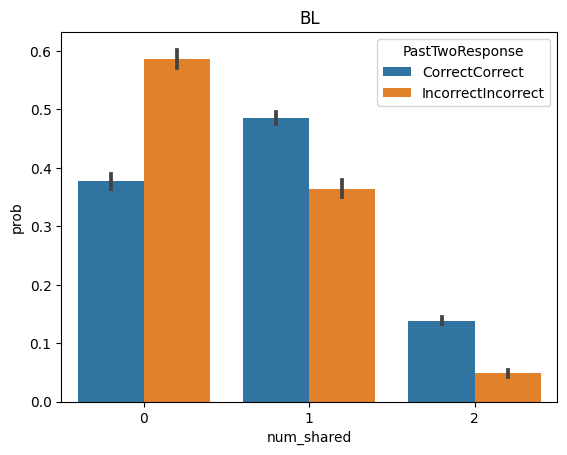

In [78]:
fig, ax = plt.subplots()
sns.barplot(data, x="num_shared", y="prob", hue="PastTwoResponse", ax=ax)
ax.set_title(subject)